## Tumor Segmentation of Brain MRI Scans with U-Net and Keras 

In [1]:
# imports 
import matplotlib.pyplot as plt
from model import Unet
from utils import dice_coefficients_loss, dice_coefficient, jaccard_distance, iou
from datasetLoader import DataGenerator
from trainGenerator import trainGenerator
from private_path import your_path
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import numpy as np
import cv2

In [2]:
# global parameters
LOCAL_MASK_PATH = your_path # Path to the Img and Mask Folder 
BATCH_SIZE = 32
EPOCHS = 150
learning_rate = 1e-4
decay_rate = learning_rate / EPOCHS
learning_rate = 1e-4
im_height = 256
im_width = 256
train_generator_augmentation_params = dict(
                              rotation_range=0.2,
                              width_shift_range=0.05,
                              height_shift_range=0.05,
                              shear_range=0.05,
                              zoom_range=0.05,
                              horizontal_flip=True,
                              fill_mode='nearest'
                              )

In [3]:
# Create a dataset from TCGA-LGG-mri-segmentation dataset 
# https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
dataset = DataGenerator(LOCAL_MASK_PATH)

# create train and test generator 
train_gen = trainGenerator(dataset.df_train, batch_size=BATCH_SIZE,
                        augmentation_dict=train_generator_augmentation_params,
                        target_size=(im_height, im_width))
test_gen = trainGenerator(dataset.df_test, batch_size=BATCH_SIZE,
                        augmentation_dict=dict(),
                        target_size=(im_height, im_width))

Df generation and train test split - done!
Train size: (3143, 2)
Test size: (393, 2)
Validation size: (786, 2)


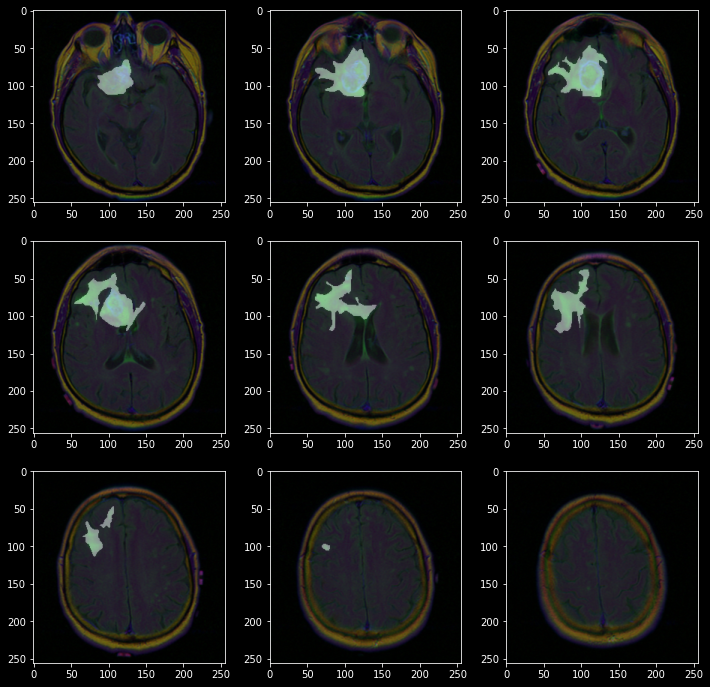

In [4]:
# Plot img+mask examples from dataset
dataset.plot_examples(3,3)

In [9]:
# Load Model with input size 256x256x3 Color Channels
model = Unet(input_size=(im_height, im_width, 3)) 
# Load Adam optimizer
optimizer = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
# Compile Model
model.compile(optimizer=optimizer, loss=dice_coefficients_loss, metrics=['binary_accuracy', iou, dice_coefficient])
# define Callback
callback = [ModelCheckpoint('brain_mri_unet_keras.hdf5', verbose=1, save_best_only=True)]

In [ ]:
# Start Training (slow in ipynb)
history = model.fit(
        train_gen,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        steps_per_epoch=len(dataset.df_train) / BATCH_SIZE,
        callbacks=callback,
        validation_data=test_gen,
        validation_steps=len(dataset.df_test) / BATCH_SIZE
)

In [ ]:
# Plot Training Acc and Loss 
history_post_training = history.history
train_dice_coeff_list = history_post_training['dice_coefficient']
test_dice_coeff_list = history_post_training['val_dice_coefficient']
plt.figure(1)
plt.plot(train_dice_coeff_list, 'b-', label='train')
plt.plot(test_dice_coeff_list, 'r-', label='test')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Dice Coefficient Graph')
plt.show()

### Load previously trained model

In [5]:
model = load_model('unet.hdf5', custom_objects={'dice_coefficients_loss': dice_coefficients_loss, 'iou': iou, 'dice_coefficient':dice_coefficient })

In [6]:
# Test Model 
test_gen = trainGenerator(dataset.df_test, batch_size=BATCH_SIZE, augmentation_dict=dict(), target_size=(im_height, im_width))
results = model.evaluate(test_gen, steps=len(dataset.df_test) / BATCH_SIZE)
print(f'Test Loss: {results[0]}\n'
      f'Test Iou: {results[1]}\n'
      f'Test Dice Coeffiecient: {results[2]}'
      )

Found 393 validated image filenames.
Found 393 validated image filenames.
12/12 [==============================] - 19s 576ms/step - loss: -0.8208 - binary_accuracy: 0.9973 - iou: 0.7043 - dice_coefficient: 0.8230
Test Loss: -0.8207579255104065
Test Iou: 0.9973452091217041
Test Dice Coeffiecient: 0.7042906880378723


### Plot predicted vs ground truth masks

1/1 [==============================] - 2s 2s/step


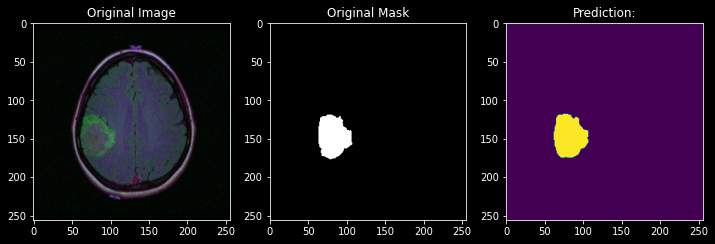

1/1 [==============================] - 0s 17ms/step


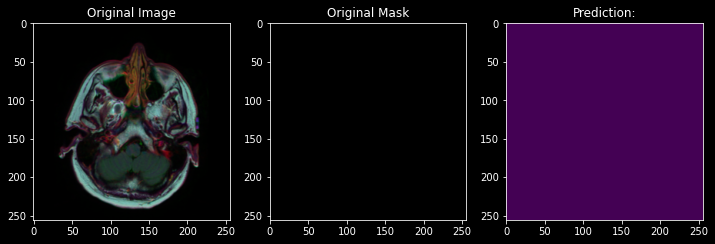

1/1 [==============================] - 0s 16ms/step


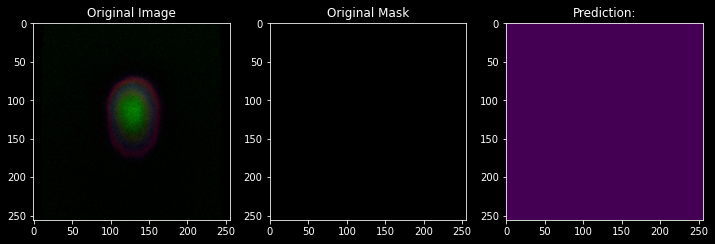

1/1 [==============================] - 0s 17ms/step


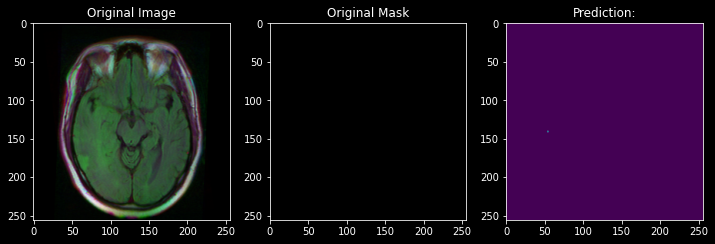

1/1 [==============================] - 0s 15ms/step


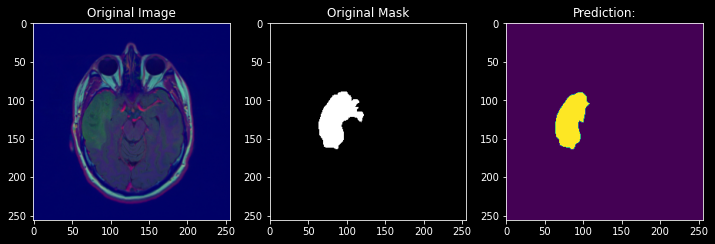

1/1 [==============================] - 0s 16ms/step


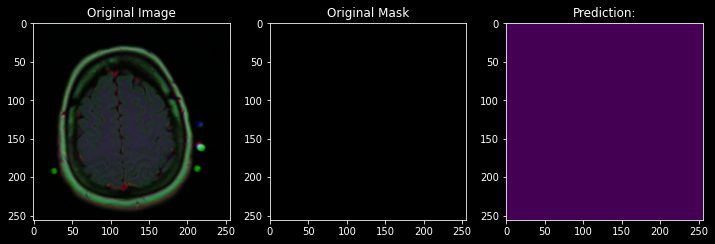

1/1 [==============================] - 0s 15ms/step


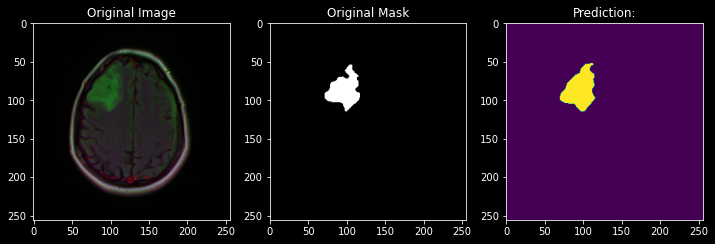

1/1 [==============================] - 0s 16ms/step


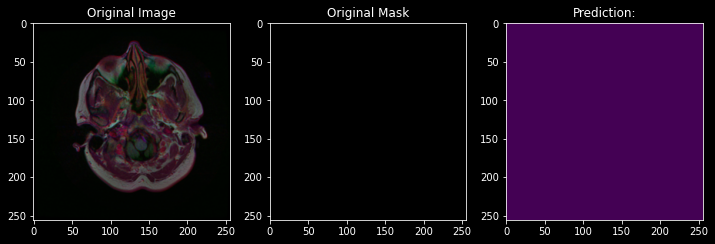

1/1 [==============================] - 0s 16ms/step


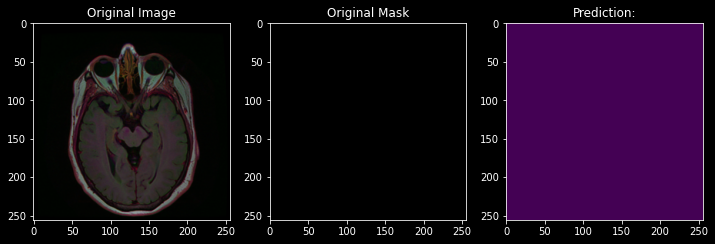

1/1 [==============================] - 0s 15ms/step


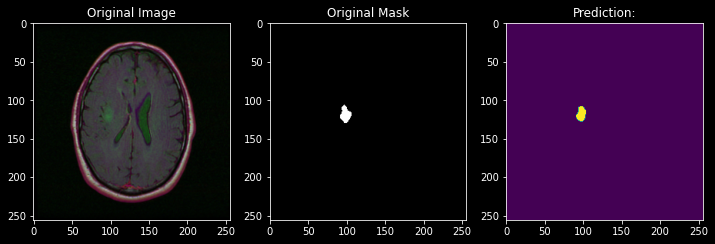

In [7]:
for i in range(10):
        # Chose Random Index in Test Dataset
        index = np.random.randint(1, len(dataset.df_test))
        # Load choosen Img
        img = cv2.imread(dataset.df_test['image_filenames'].iloc[index])
        img = cv2.resize(img, (im_height, im_width))
        img = img/255
        # print(imgs.shape) (256, 256 , 3)
        img = img[np.newaxis, :, :, : ]
        # print(img.shape) # (1, 256, 256, 3)

        predicted_img = model.predict(img)
        
        plt.figure(figsize=(12, 12))
        plt.style.use('dark_background')
        plt.subplot(1, 3, 1)
        plt.imshow(np.squeeze(img))
        plt.title('Original Image')

        plt.subplot(1, 3, 2)
        plt.imshow(np.squeeze(cv2.imread(dataset.df_test['mask'].iloc[index])))
        plt.title('Original Mask')

        plt.subplot(1, 3, 3)
        plt.imshow(np.squeeze(predicted_img) > 0.5 )
        plt.title('Prediction:')
        plt.show()